In [1]:
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
import numpy as np
import warnings
import random 
from scipy.interpolate import RBFInterpolator
from scipy.spatial import KDTree
import numba 
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
random.seed(0)
warnings.filterwarnings('ignore', category=UserWarning)

c:\Users\Compuworld\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Reading in the dataset
X, y = make_classification(n_samples=2000, n_features=2, n_informative=2,
                           n_redundant=0, n_classes=2, random_state=42)
def visualize_dataset():
    plt.figure(figsize=(8, 6))

    plt.scatter(X[y == 0].iloc[:, 0], X[y == 0].iloc[:, 1], color='blue', label='Class 0', alpha=0.5)
    plt.scatter(X[y == 1].iloc[:, 0], X[y == 1].iloc[:, 1], color='red', label='Class 1', alpha=0.5)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Binary Classification Data (2 Features)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [3]:
def closest_point(point, contour):
    tree = KDTree(contour)
    closest_index = tree.query(point)[1]
    if not isinstance(closest_index, np.int64): 
        closest_index = closest_index[0]
    closest_point = contour[closest_index]
    return closest_point

def closest_border_point(border_points, contour): 
    # Build a KDTree for fast nearest neighbor search
    tree = KDTree(contour) 

    min_point, total_min = None, float('inf')

    for border_point in border_points: 
        # Find the distance and index of the closest contour point using KDTree
        dist, _ = tree.query(border_point)

        # Update the minimum point and distance if a closer point is found
        if dist < total_min: 
            total_min = dist 
            min_point = border_point 
    
    return min_point

def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

In [4]:
def move_from_A_to_B_with_x1_displacement(A, B, deltas, epsilon=1e-3):
    """
    Move from point A to point B in n-dimensional space with a desired movement in the x1 dimension.
    
    Parameters:
    - A: list or np.array, coordinates of the starting point A
    - B: list or np.array, coordinates of the target point B
    - delta_x1: float, the desired displacement in the x1 dimension
    
    Returns:
    - P: np.array, coordinates of the new point after moving delta_x1 along x1-axis
    """
    A = np.array(A)
    B = np.array(B)
    
    # Calculate direction vector from A to B
    D = B - A
    
    # Calculate the scaling factor t for the desired movement in x1
    t = deltas / (D + epsilon)   # D[0] is the x1 component of the direction vector
    
    # Calculate the new point P based on t
    P = A + t * D

    print(t) 
    print(D)
    
    return P

# Example usage
A = [1, 2, 3]  # Starting point in 3D space
B = [4, 5, 6]  # Target point in 3D space
delta_x1 = 1.5  # Desired movement in x1 dimension

P = move_from_A_to_B_with_x1_displacement(A, B, delta_x1)
print("New point P with desired x1 movement:", P)

[0.49983339 0.49983339 0.49983339]
[3 3 3]
New point P with desired x1 movement: [2.49950017 3.49950017 4.49950017]


In [ ]:
def alpha_binary_search(model, point, opp_point, point_target, opp_target, epsilon=0.01): 
    start, end = 0, 1
    while abs(end - start) >= epsilon: 
        alpha = (start + end) / 2  # Fix: float division
        temp_candidate = (1 - alpha) * point + alpha * opp_point
        temp_target = model.predict([temp_candidate])[0]
        if temp_target == point_target: 
            start = alpha 
            point_target = temp_target
        elif temp_target == opp_target: 
            end = alpha 
            opp_target = temp_target
    return (start + end) / 2


def find_decision_boundary(model, X, y, epsilon=1e-3, threshold=10000):
    categorical_features = X.select_dtypes(include=int).columns.tolist()
    cat_indices = [X.columns.get_loc(col) for col in categorical_features]

    bool_vec = [1] * (len(X.columns)) 

    for i in range(len(cat_indices)): 
        bool_vec[cat_indices[i]] = 0 

    X_np= X.to_numpy() 
    y_np = y.to_numpy()
    boundary_points = []
    unique_labels = np.unique(y_np)
    if len(unique_labels) != 2:
        raise ValueError("Only supports binary classification.")
    
    label_a, label_b = unique_labels[0], unique_labels[1]

    cluster_a = X_np[y == label_a]
    cluster_b = X_np[y == label_b]

    total_N = 0 
    for i in range(cluster_a.shape[0]):
        point = cluster_a[i]
        pt_pred = model.predict([point])

        for j in range(cluster_b.shape[0]): 
            match_point = cluster_b[j]
            match_pt_pred = model.predict([match_point])
            if pt_pred.item() == label_a and match_pt_pred.item() == label_b: 
                alpha= alpha_binary_search(model, point, match_point, label_a, label_b, epsilon=epsilon)
                boundary = (1 - alpha) * point + alpha * match_point
                boundary_points.append(boundary)

                total_N+=1
                if total_N >= threshold: 
                    break
        if total_N >= threshold: 
            break
    
    boundary_pts = pd.DataFrame(data=boundary_points, columns=X.columns)

    for col in categorical_features: 
        boundary_pts[col] = boundary_pts[col].astype(int)

    return boundary_pts

In [55]:
def get_multi_dim_border_points(center, extents, step=0.1):
    """
    Generate points on the boundaries of an n-dimensional hyperrectangle.
    
    Parameters:
    - center: List or array of length n, the center of the hyperrectangle.
    - extents: List or array of length n, the half-widths in each dimension.
    - step: Float, step size for sampling points along each dimension.
    
    Returns:
    - List of tuples, each tuple representing a point on the boundary.
    """
    center = np.array(center)
    extents = np.array(extents)
    n = len(center)  # Number of dimensions
    points = set()   # Use set to avoid duplicates
    
    # Define min and max bounds for each dimension
    bounds = [(c - e / 2, c + e / 2) for c, e in zip(center, extents)]
    
    # For each dimension, generate points on the lower and upper boundaries
    for dim in range(n):
        # For lower and upper boundary in this dimension
        for bound_val in [bounds[dim][0], bounds[dim][1]]:
            # Generate grid points for all other dimensions
            other_dims = [i for i in range(n) if i != dim]
            ranges = [np.arange(bounds[i][0], bounds[i][1] + step, step) for i in other_dims]
            if not ranges:  # Handle 1D case
                points.add(tuple([bound_val] if dim == 0 else []))
                continue
            # Create meshgrid for other dimensions
            grids = np.meshgrid(*ranges, indexing='ij')
            coords = [grid.ravel() for grid in grids]
            
            # Construct points
            for coord in zip(*coords):
                point = [0] * n
                # Set the current dimension to the boundary value
                point[dim] = bound_val
                # Set other dimensions to the grid values
                for i, val in zip(other_dims, coord):
                    point[i] = val
                points.add(tuple(point))
    
    return list(points)

def det_constraints(datapt, deltas): 
    constraints = [-1] * len(deltas) 
    len_constr = 0 
    for i in range(len(deltas)): 
        if type(deltas[i]) == float or type(deltas[i]) == int:
            constraints[i] = (deltas[i]/100)*datapt[i]
            len_constr+=1
    return constraints, len_constr

def constraint_bounds(contours, datapt, constraints): 
    if len(constraints) == 0: 
        raise Exception("No constraints were assigned.")
    bounded_contour = contours.copy() 
    for i in range(len(constraints)): 
        if constraints[i] > 0:
            x = datapt[0][i]
            # This should just be the delta
            delta_x = constraints[i]
            # Generate a lower and upper bounds on each constraint
            lowb_x, highb_x = x - (delta_x / 2), x + (delta_x / 2)
            contour_arr = bounded_contour[:, i]
            # Choose the correct indices for the multi-dimensional df
            indices = np.where((contour_arr >= lowb_x) & (contour_arr <= highb_x))
            bounded_contour_pts = bounded_contour[indices]
            bounded_contour = bounded_contour_pts
            if i == 0:
                plt.axvline(x=highb_x, color='b', linestyle='-', label='High Bound x')
                plt.axvline(x=lowb_x, color='b', linestyle='-', label='Low bound x')
            else: 
                plt.axhline(y=highb_x, color='b', linestyle='-', label='High Bound y')
                plt.axhline(y=lowb_x, color='b', linestyle='-', label='Low bound y')
    return bounded_contour

#constraints = [("gender", "equal"), ("age", "greater"), ("height", "equal"), ("family_history_with_overweight", "equal")]
def real_world_constraints(points, undesired_coords, constraints): 
# [("gender", "equal"), ("age", "greater"), ("height", "equal"), ("family_history_with_overweight", "equal")]
    if len(constraints) == 0: 
        return points 
    
    for constraint in constraints: 
        select_pts = None
        if constraint[1] == "equal": 
            select_pts = points.loc[points[constraint[0]] == undesired_coords[points.columns.get_loc(constraint[0])], :]
        elif constraint[1] == "greater": 
            select_pts = points.loc[points[constraint[0]] > undesired_coords[points.columns.get_loc(constraint[0])], :] 
        else: 
            select_pts = points.loc[points[constraint[0] < undesired_coords[points.columns.get_loc(constraint[0])]], :]

        points = select_pts
    
    return points

In [71]:
# Algorithm that determines the point that is closest to the decision boundary from a specified data point (undesired_coords) 
def optimal_point(dataset, model, desired_class, original_class, undesired_coords, threshold=10000, point_epsilon=0.1, epsilon=0.01, constraints=[], deltas=[]): 
    X_train, y_train = dataset.iloc[:, 0:dataset.shape[1]-1], dataset.iloc[:, -1]
    n_features = X_train.shape[1]

    print("fitting model...")
    model.fit(X_train, y_train)
    print("model finished.")

    print("boundary points started generation...")
    # IMPORTANT # 
    # We are replacing the grid-based approach with the binary search approach
    # Instead of building a grid in N-dimensions, we use binary search to find points on the decision boundary
    boundary_points = find_decision_boundary(model, X_train, y_train, threshold=threshold, epsilon=point_epsilon)
    print("boundary points finished.")
    print(boundary_points.shape)    

    # Fitting the boundary points to the constraints provided by the real world
    contours = real_world_constraints(points=boundary_points, undesired_coords=undesired_coords, constraints=constraints)
    contours = np.unique(contours.to_numpy(),axis=0)
    
    # print("Generating the final contour for multi-dimensional interpolation finished.")
    undesired_datapt = np.reshape(np.array(list(undesired_coords)), (1, -1))
    # Find the closest point from the undesired point to the contour line
    print("Finding the closest point from the contour line to the point...")
    optimal_datapt = closest_point(undesired_datapt, contour=contours)
    print("Finding the closest point from the contour line to the point.")

    # Uncomment for Plotting
    plt.plot(contours[:,0], contours[:,1], lw=2.5, color='black')
    plt.scatter(X_train[y_train == desired_class].iloc[:, 0], X_train[y_train == desired_class].iloc[:, 1], color='blue', alpha=0.5)
    plt.scatter(X_train[y_train == original_class].iloc[:, 0], X_train[y_train == original_class].iloc[:, 1], color='red', alpha=0.5)
    if desired_class != original_class: 
        D = optimal_datapt - undesired_datapt
        deltas = D * (1+epsilon)
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, optimal_datapt, deltas=deltas)
    else:
        closest_boundedpt = None
        deltas, len_constr = det_constraints(datapt=undesired_datapt[0], deltas=deltas)
        bounded_contour_pts = None

        if len_constr > n_features: 
            raise Exception("There cannot be more constraints than features")
        elif len_constr == n_features:
            bounded_contour_pts = get_multi_dim_border_points(center=undesired_datapt[0], extents=deltas, step=0.05)
            np_bounded_contour = np.array(bounded_contour_pts)
            x_values, y_values = np_bounded_contour[:,0], np_bounded_contour[:, 1]
            closest_boundedpt = closest_border_point(bounded_contour_pts, contour=contours)
        else: 
            # Generate bounded contour points
            bounded_contour_pts = constraint_bounds(contours, undesired_datapt, deltas)
            closest_boundedpt = closest_point(point=undesired_datapt, contour=bounded_contour_pts)

        D = closest_boundedpt - undesired_datapt
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, closest_boundedpt, deltas=D)
    # Uncomment for Plotting
    plt.scatter(undesired_datapt[0][0], undesired_datapt[0][1], c = 'r')
    plt.text(undesired_datapt[0][0]+0.002, undesired_datapt[0][1]+0.002, 'NH')
    plt.scatter(optimal_datapt[0][0], optimal_datapt[0][1], c = 'r')
    plt.text(optimal_datapt[0][0]+0.002, optimal_datapt[0][1]+0.002, 'NH')
    plt.plot([undesired_datapt[0][0], optimal_datapt[0][0]], [undesired_datapt[0][1],optimal_datapt[0][1]], linestyle='--')
    return optimal_datapt

fitting model...
model finished.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07438268 1.07023586]]
[[-0.24514294 -4.53761911]]


array([[10.73662268, 10.14367731]])

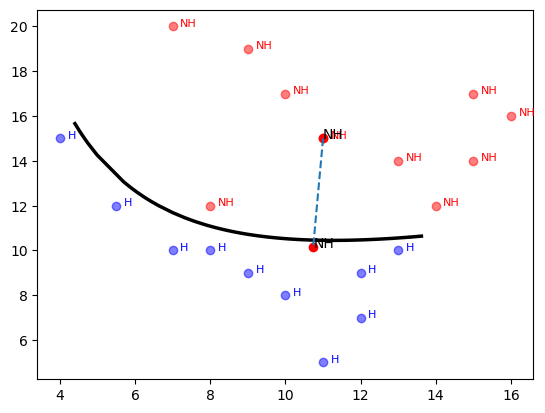

In [60]:
# Reading in the dataset
df=pd.read_csv('SVM_Dataset2.csv')
df = df.astype('Float32')

# SVM classifier with polynomial decision boundary
svm_classifier = svm.SVC(kernel='poly',C=10, degree=2, probability=True)
# svm_classifier = svm.SVC(kernel='rbf', gamma=0.1, C=100)
optimal_point(df, model=svm_classifier, desired_class=1, original_class=-1, threshold=100000, undesired_coords=(11,15), point_epsilon=1e-6, epsilon=0.07)

fitting model...
model finished.
boundary points started generation...
boundary points finished.
(90, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07075885 1.07043185]]
[[-1.41102648 -2.47870874]]


array([[ 9.48913091, 12.34671121]])

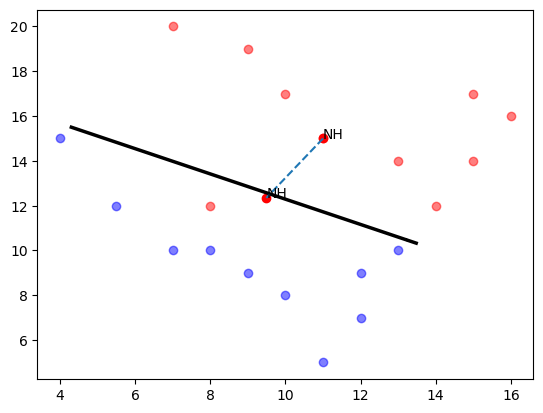

In [72]:
# Reading in the dataset
df=pd.read_csv('SVM_Dataset2.csv')
df = df.astype('Float32')

log_reg_clf = LogisticRegression()
# svm_classifier = svm.SVC(kernel='rbf', gamma=0.1, C=100)
optimal_point(df, model=log_reg_clf, desired_class=1, original_class=-1, threshold=100000, undesired_coords=(11,15), point_epsilon=1e-6, epsilon=0.07)

In [62]:
X, y = make_classification(n_samples=200, n_features=2, n_informative=2,
                           n_redundant=0, n_classes=2, random_state=42)
y = y.reshape(-1,1)
df1 = pd.DataFrame(data=np.hstack((X,y)))
log_reg_clf = LogisticRegression()

In [63]:
df1.head(n=20)

,0,1,2
0,1.689767,-1.408241,1.0
1,1.530287,-1.459848,1.0
2,-1.175042,-1.447633,0.0
3,-2.585395,0.963532,0.0
4,1.372246,0.440695,1.0
5,0.731936,0.849753,1.0
6,-2.106842,-0.156005,0.0
7,-0.936016,0.543282,0.0
8,-1.646995,0.493409,0.0
9,0.425361,0.241427,0.0


fitting model...
model finished.
boundary points started generation...
boundary points finished.
(50000, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0917512  1.07123276]]
[[-0.05019268 -0.86897378]]


array([[ 1.16902233, -0.03820912]])

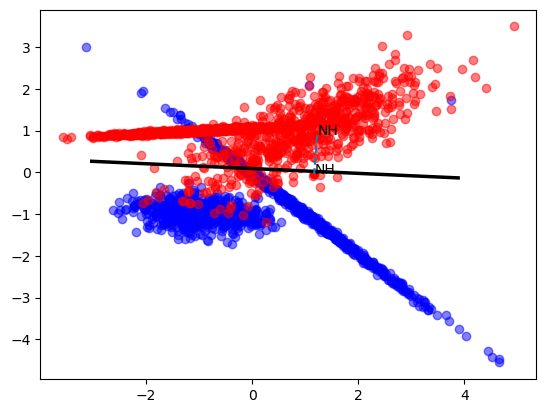

In [74]:
optimal_point(df1, model=log_reg_clf, desired_class=0, original_class=1, threshold=50000, undesired_coords=df1.iloc[19,:df1.shape[1]-1], point_epsilon=1e-6, epsilon=0.07)

In [65]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2,
                           n_redundant=0, n_classes=2, random_state=41)
y = y.reshape(-1,1)
df1 = pd.DataFrame(data=np.hstack((X,y)))
log_reg_clf = LogisticRegression()


In [66]:
df1.head(n=20)

,0,1,2
0,-0.397259,-1.283835,0.0
1,0.201367,1.892723,1.0
2,0.678549,0.900655,0.0
3,-1.143368,-2.649696,0.0
4,-0.768880,0.942199,1.0
5,-1.239620,0.960955,1.0
6,2.677535,-0.870472,1.0
7,-0.402468,-0.721900,0.0
8,0.375955,1.666805,1.0
9,1.317282,-0.057217,0.0


fitting model...
model finished.
boundary points started generation...
boundary points finished.
(40000, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07400543 1.07093607]]
[[-0.26813703 -1.14407784]]


array([[ 0.56444996, -0.03518529]])

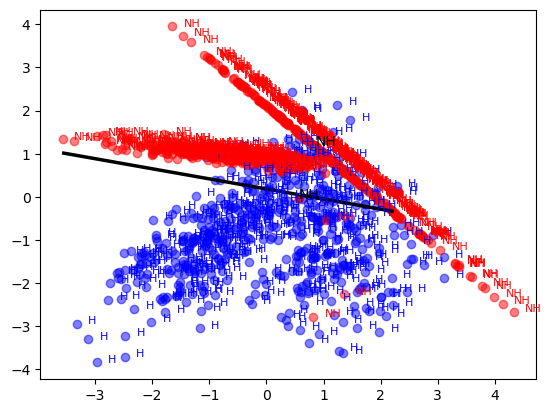

In [67]:
optimal_point(df1, model=log_reg_clf, desired_class=0, original_class=1, threshold=40000, undesired_coords=df1.iloc[11,:df1.shape[1]-1], point_epsilon=1e-6, epsilon=0.07)

In [68]:
X, y = make_classification(n_samples=2500, n_features=2, n_informative=2,
                           n_redundant=0, n_classes=2, random_state=41)
y = y.reshape(-1,1)
df1 = pd.DataFrame(data=np.hstack((X,y)))
log_reg_clf = LogisticRegression()

In [69]:
df1.head(n=10)

,0,1,2
0,-2.399438,0.889132,1.0
1,0.480615,-0.584978,0.0
2,-1.546409,0.962876,1.0
3,1.344661,1.163775,1.0
4,-1.555625,-0.972041,0.0
5,0.377278,-0.347871,0.0
6,-1.494532,0.955231,1.0
7,0.761320,1.463694,1.0
8,1.475406,1.380131,1.0
9,1.598489,0.680961,1.0


fitting model...
model finished.
boundary points started generation...
boundary points finished.
(40000, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0864964  1.07093438]]
[[-0.06586263 -1.14614907]]


array([[ 1.27310108, -0.06367502]])

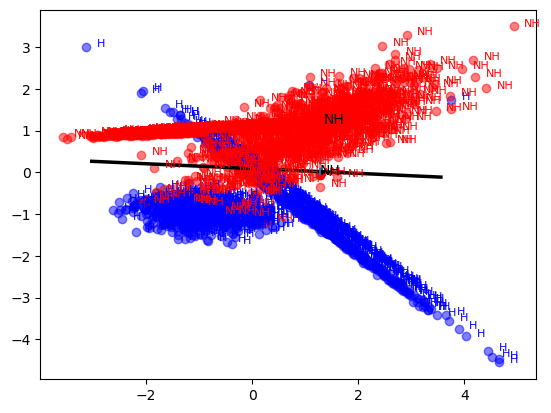

In [70]:
optimal_point(df1, model=log_reg_clf, desired_class=0, original_class=1, threshold=40000, undesired_coords=df1.iloc[3,:df1.shape[1]-1], point_epsilon=1e-6, epsilon=0.07)